In [1]:
import pdb
import os
from pickletools import optimize
from shutil import SpecialFileError
import time
import random
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter

from config import get_config
from models import build_model
from data import build_loader
from lr_scheduler import build_scheduler
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, load_pretrained, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor

In [2]:
import matplotlib.pyplot as plt

In [3]:
def parse_option(config_path, output_path, tag):
    parser = argparse.ArgumentParser('Swin Transformer training and evaluation script', add_help=False)
    parser.add_argument('--cfg', type=str, metavar="FILE", help='path to config file', 
                        default=config_path)
    parser.add_argument(
        "--opts",
        help="Modify config options by adding 'KEY VALUE' pairs. ",
        default=None,
        nargs='+',
    )

    # easy config modification
    parser.add_argument('--batch-size', type=int, help="batch size for single GPU")
    parser.add_argument('--data-path', type=str, help='path to dataset', default=1)
    parser.add_argument('--zip', action='store_true', help='use zipped dataset instead of folder dataset')
    parser.add_argument('--cache-mode', type=str, default='part', choices=['no', 'full', 'part'],
                        help='no: no cache, '
                             'full: cache all data, '
                             'part: sharding the dataset into nonoverlapping pieces and only cache one piece')
    parser.add_argument('--pretrained',
                        help='pretrained weight from checkpoint, could be imagenet22k pretrained weight')
    parser.add_argument('--resume', help='resume from checkpoint')
    parser.add_argument('--accumulation-steps', type=int, help="gradient accumulation steps")
    parser.add_argument('--use-checkpoint', action='store_true',
                        help="whether to use gradient checkpointing to save memory")
    parser.add_argument('--amp-opt-level', type=str, default='O0', choices=['O0', 'O1', 'O2'],
                        help='mixed precision opt level, if O0, no amp is used')
    parser.add_argument('--output', default=output_path, type=str, metavar='PATH',
                        help='root of output folder, the full path is <output>/<model_name>/<tag> (default: output)')
    parser.add_argument('--tag', help='tag of experiment', default=tag)
    parser.add_argument('--eval', action='store_true', help='Perform evaluation only')
    parser.add_argument('--throughput', action='store_true', help='Test throughput only')

    # distributed training
    parser.add_argument(
        "--local_rank", type=int, help='local rank for DistributedDataParallel', default=0
    )

    args, unparsed = parser.parse_known_args()

    config = get_config(args)

    return args, config

def build_val_loader(config):
    from data.build import build_dataset
    from timm.data import Mixup
    config.defrost()
    dataset_train, config.MODEL.NUM_CLASSES = build_dataset(is_train=True, config=config)
    config.freeze()
    dataset_val, _ = build_dataset(is_train=False, config=config)

    

    sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=config.DATA.BATCH_SIZE,
        shuffle=False,
        num_workers=config.DATA.NUM_WORKERS,
        pin_memory=config.DATA.PIN_MEMORY,
        drop_last=False
    )

    # setup mixup / cutmix
    mixup_fn = None
    mixup_active = config.AUG.MIXUP > 0 or config.AUG.CUTMIX > 0. or config.AUG.CUTMIX_MINMAX is not None
    if mixup_active:
        mixup_fn = Mixup(
            mixup_alpha=config.AUG.MIXUP, cutmix_alpha=config.AUG.CUTMIX, cutmix_minmax=config.AUG.CUTMIX_MINMAX,
            prob=config.AUG.MIXUP_PROB, switch_prob=config.AUG.MIXUP_SWITCH_PROB, mode=config.AUG.MIXUP_MODE,
            label_smoothing=config.MODEL.LABEL_SMOOTHING, num_classes=config.MODEL.NUM_CLASSES)

    return dataset_val, data_loader_val, mixup_fn

@torch.no_grad()
def validate(config, data_loader, model, accumulation_steps=1):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        formatted_images = images.cuda(non_blocking=True).unsqueeze(0)
        formatted_target = target.cuda(non_blocking=True).unsqueeze(0)
        
        A, B, C, H, W = formatted_images.shape
        A, B = formatted_target.shape
        if B // accumulation_steps == 0:
            zero_idx = 1
            ones_idx = B
        else:
            zero_idx = accumulation_steps
            ones_idx = B // accumulation_steps
        formatted_images = formatted_images.reshape(zero_idx, ones_idx, C, H, W)
        formatted_target = formatted_target.reshape(zero_idx, ones_idx)
        
        for accumulation_step in range(accumulation_steps):
            images = formatted_images[accumulation_step]
            target = formatted_target[accumulation_step]
        
            # compute output
            output = model(images, use_amp=False)

            # measure accuracy and record loss
            loss = criterion(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

    #         acc1 = acc1
    #         acc5 = reduce_tensor(acc5)
    #         loss = reduce_tensor(loss)

            loss_meter.update(loss.item(), target.size(0))
            acc1_meter.update(acc1.item(), target.size(0))
            acc5_meter.update(acc5.item(), target.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % config.PRINT_FREQ == 0:
                memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
                print(
                    f'Test: [{idx}/{len(data_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                    f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                    f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                    f'Mem {memory_used:.0f}MB')
            images = images.cpu()
            target = target.cpu()
    print(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg

# Swin Transformer Baseline

In [3]:
config_path = 'configs/swin_tiny_patch4_window7_224_cifar100.yaml'
output_path = '/srv/share4/gstoica3/checkpoints/swin_transformer_cifar'
tag = 'baseline_fp32'
_, config = parse_option(config_path, output_path, tag)

=> merge config from configs/swin_tiny_patch4_window7_224_cifar100.yaml


In [4]:
config

CfgNode({'BASE': [''], 'DATA': CfgNode({'BATCH_SIZE': 128, 'DATA_PATH': 1, 'DATASET': 'cifar100', 'IMG_SIZE': 224, 'INTERPOLATION': 'bicubic', 'ZIP_MODE': False, 'CACHE_MODE': 'part', 'PIN_MEMORY': True, 'NUM_WORKERS': 8}), 'MODEL': CfgNode({'TYPE': 'swin', 'NAME': 'swin_tiny_patch4_window7_224_cifar100', 'PRETRAINED': '', 'RESUME': '', 'NUM_CLASSES': 1000, 'DROP_RATE': 0.0, 'DROP_PATH_RATE': 0.2, 'LABEL_SMOOTHING': 0.1, 'SWIN': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'QKV_BIAS': True, 'QK_SCALE': None, 'APE': False, 'PATCH_NORM': True, 'SUMMARY_TYPE': 'none', 'SUMMARY_LAYERS': []}), 'SWIN_MLP': CfgNode({'PATCH_SIZE': 4, 'IN_CHANS': 3, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'NUM_HEADS': [3, 6, 12, 24], 'WINDOW_SIZE': 7, 'MLP_RATIO': 4.0, 'APE': False, 'PATCH_NORM': True}), 'CSAM': CfgNode({'APPROACH_NAME': 'Three_unmasked', 'POS_EMB_DIM': 0, 'SOFTMAX_TEMP': 1, 'PADDING': 'same',

In [5]:
seed = config.SEED
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [6]:
config.defrost()
config.TRAIN.BASE_LR = .000001
config.TRAIN.WARMUP_LR = .000001
config.TRAIN.MIN_LR = .000001
config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
config.freeze()

In [7]:
dataset_val, data_loader_val, mixup_fn = build_val_loader(config)

Files already downloaded and verified
Files already downloaded and verified


/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
model = build_model(config)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
model.cuda()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [10]:
resume_file = auto_resume_helper(config.OUTPUT)

All checkpoints founded in /srv/share4/gstoica3/checkpoints/swin_transformer_cifar/swin_tiny_patch4_window7_224_cifar100/baseline_fp32: ['ckpt_epoch_11.pth', 'ckpt_epoch_228.pth', 'ckpt_epoch_143.pth', 'ckpt_epoch_285.pth', 'ckpt_epoch_254.pth', 'ckpt_epoch_192.pth', 'ckpt_epoch_144.pth', 'ckpt_epoch_282.pth', 'ckpt_epoch_253.pth', 'ckpt_epoch_195.pth', 'ckpt_epoch_16.pth', 'ckpt_epoch_138.pth', 'ckpt_epoch_64.pth', 'ckpt_epoch_18.pth', 'ckpt_epoch_136.pth', 'ckpt_epoch_221.pth', 'ckpt_epoch_131.pth', 'ckpt_epoch_226.pth', 'ckpt_epoch_63.pth', 'ckpt_epoch_213.pth', 'ckpt_epoch_104.pth', 'ckpt_epoch_87.pth', 'ckpt_epoch_56.pth', 'ckpt_epoch_5.pth', 'ckpt_epoch_178.pth', 'ckpt_epoch_80.pth', 'ckpt_epoch_51.pth', 'ckpt_epoch_2.pth', 'ckpt_epoch_268.pth', 'ckpt_epoch_214.pth', 'ckpt_epoch_103.pth', 'ckpt_epoch_266.pth', 'ckpt_epoch_171.pth', 'ckpt_epoch_23.pth', 'ckpt_epoch_24.pth', 'ckpt_epoch_89.pth', 'ckpt_epoch_58.pth', 'ckpt_epoch_261.pth', 'ckpt_epoch_176.pth', 'ckpt_epoch_35.pth', '

In [11]:
config.defrost()
config.MODEL.PRETRAINED = resume_file
config.freeze()


In [12]:
load_pretrained(config, model)

In [13]:
acc1, acc5, loss = validate(config, data_loader_val, model, accumulation_steps=4)

Test: [0/79]	Time 3.708 (3.708)	Loss 0.7454 (0.7454)	Acc@1 75.000 (75.000)	Acc@5 100.000 (100.000)	Mem 734MB
Test: [0/79]	Time 0.109 (1.908)	Loss 0.7289 (0.7372)	Acc@1 84.375 (79.688)	Acc@5 93.750 (96.875)	Mem 734MB
Test: [0/79]	Time 0.057 (1.291)	Loss 0.9836 (0.8193)	Acc@1 68.750 (76.042)	Acc@5 96.875 (96.875)	Mem 734MB
Test: [0/79]	Time 0.075 (0.987)	Loss 0.6413 (0.7748)	Acc@1 87.500 (78.906)	Acc@5 100.000 (97.656)	Mem 734MB
Test: [10/79]	Time 0.054 (0.143)	Loss 0.8635 (0.9322)	Acc@1 75.000 (77.134)	Acc@5 96.875 (94.436)	Mem 734MB
Test: [10/79]	Time 0.047 (0.141)	Loss 1.2669 (0.9402)	Acc@1 71.875 (77.009)	Acc@5 87.500 (94.271)	Mem 734MB
Test: [10/79]	Time 0.047 (0.139)	Loss 0.7704 (0.9363)	Acc@1 81.250 (77.108)	Acc@5 93.750 (94.259)	Mem 734MB
Test: [10/79]	Time 0.046 (0.137)	Loss 1.1476 (0.9411)	Acc@1 68.750 (76.918)	Acc@5 93.750 (94.247)	Mem 734MB
Test: [20/79]	Time 0.050 (0.096)	Loss 0.7611 (0.9311)	Acc@1 78.125 (76.890)	Acc@5 96.875 (94.406)	Mem 734MB
Test: [20/79]	Time 0.047 (0.0

In [21]:
for idx, (images, target) in enumerate(data_loader_val):
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)
    break

In [19]:
def obtain_baseline_model_features(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
        x = layer(x)
    return {
        'input_features': x,
        'output_features': layer(x)
    }

In [22]:
features = obtain_baseline_model_features(model, images, 0)

In [24]:
features['input_features'].shape, features['output_features'].shape

(torch.Size([128, 3136, 96]), torch.Size([128, 784, 192]))

In [25]:
from sklearn.decomposition import PCA

In [26]:
input_PCA = PCA(n_components=3)
output_PCA = PCA(n_components=3)

In [30]:
input_PCA.fit(features['input_features'].detach().cpu().numpy().reshape(-1, 96))
output_PCA.fit(features['output_features'].detach().cpu().numpy().reshape(-1, 192))

PCA(n_components=3)

In [31]:
flattened_inputs = features['input_features'].detach().cpu().numpy().reshape(-1, 96)
flattened_outputs = features['output_features'].detach().cpu().numpy().reshape(-1, 192)

In [39]:
reduced_inputs = input_PCA.transform(flattened_inputs).reshape(128, 3136, 3).reshape(128, 56, 56, 3)
reduced_outputs = output_PCA.transform(flattened_outputs).reshape(128, 784, 3).reshape(128, 28, 28, 3)

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


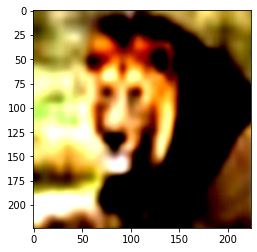

In [49]:
plt.imshow(images[117].permute(1, 2, 0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


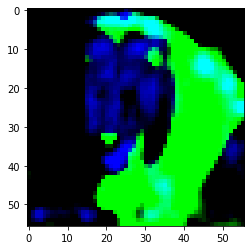

In [50]:
plt.imshow(reduced_inputs[117])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


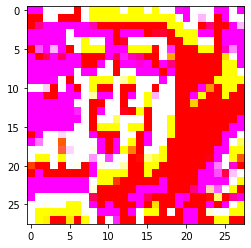

In [51]:
plt.imshow(reduced_outputs[117])

# CSAM Model

In [4]:
config_path = 'configs/csam_tiny_patch4_window7_224_cifar.yaml'
output_path = '/srv/share4/gstoica3/checkpoints/swin_csam1Appr3_transformer_cifar'
tag = 'filter_size_3'
_, config = parse_option(config_path, output_path, tag)

=> merge config from configs/csam_tiny_patch4_window7_224_cifar.yaml


In [5]:
seed = config.SEED
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [6]:
config.defrost()
config.TRAIN.BASE_LR = .000001
config.TRAIN.WARMUP_LR = .000001
config.TRAIN.MIN_LR = .000001
config.DATA.DATA_PATH = '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python'
config.freeze()

In [7]:
dataset_val, data_loader_val, mixup_fn = build_val_loader(config)

Files already downloaded and verified
Files already downloaded and verified


/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
csam_model = build_model(config)

/srv/share/gstoica3/miniconda3/envs/cifar/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ADDING CSAM!!!!


In [21]:
csam_model.cuda()
# csam_resume_file = auto_resume_helper(config.OUTPUT)
csam_resume_file = '/srv/share4/gstoica3/checkpoints/swin_csam1Appr3_transformer_cifar/csam_tiny_patch4_window7_224_cifar/filter_size_3/ckpt_epoch_291.pth'
config.defrost()
config.MODEL.PRETRAINED = csam_resume_file
config.freeze()
load_pretrained(config, csam_model)

In [22]:
csam_acc1, csam_acc5, csam_loss = validate(config, data_loader_val, csam_model, accumulation_steps=4)

Test: [0/79]	Time 1.128 (1.128)	Loss 0.7629 (0.7629)	Acc@1 75.000 (75.000)	Acc@5 100.000 (100.000)	Mem 835MB
Test: [0/79]	Time 0.107 (0.618)	Loss 0.6961 (0.7295)	Acc@1 84.375 (79.688)	Acc@5 93.750 (96.875)	Mem 835MB
Test: [0/79]	Time 0.083 (0.440)	Loss 1.0143 (0.8244)	Acc@1 75.000 (78.125)	Acc@5 96.875 (96.875)	Mem 835MB
Test: [0/79]	Time 0.081 (0.350)	Loss 0.6571 (0.7826)	Acc@1 87.500 (80.469)	Acc@5 100.000 (97.656)	Mem 835MB
Test: [10/79]	Time 0.055 (0.082)	Loss 0.8248 (0.8883)	Acc@1 75.000 (79.116)	Acc@5 96.875 (95.122)	Mem 835MB
Test: [10/79]	Time 0.051 (0.081)	Loss 1.2379 (0.8967)	Acc@1 75.000 (79.018)	Acc@5 84.375 (94.866)	Mem 835MB
Test: [10/79]	Time 0.051 (0.081)	Loss 0.8682 (0.8960)	Acc@1 75.000 (78.924)	Acc@5 93.750 (94.840)	Mem 835MB
Test: [10/79]	Time 0.056 (0.080)	Loss 0.9907 (0.8981)	Acc@1 71.875 (78.764)	Acc@5 96.875 (94.886)	Mem 835MB
Test: [20/79]	Time 0.055 (0.067)	Loss 0.7432 (0.8830)	Acc@1 84.375 (78.974)	Acc@5 96.875 (94.946)	Mem 835MB
Test: [20/79]	Time 0.051 (0.0

In [13]:
for idx, (images, target) in enumerate(data_loader_val):
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)
    break

In [ ]:
def get_csam_module(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
    return layer, x


def get_module_representation(self, batch):
    valid_elements = (1 - self.padding_mask)
    X = self.maybe_add_positional_encodings(batch)                                                                  # [B,H,W,E]
    batch_size, H, W, _ = X.shape
    X = X.view(-1, H * W, X.shape[-1])                                                                              # [B,HW,E]
    values = self.global_transform(X)                                                                               # [B,HW,C]

    X_normed = F.normalize(X, dim=-1)                                                                               # [B,HW,C]
    if self.approach_args.SIMILARITY_METRIC == 'cosine_similarity':
        scores = torch.bmm(X_normed, X_normed.transpose(2, 1))                                                      # [B,HW,HW]
    elif self.approach_args.SIMILARITY_METRIC == 'dot_product':
        scores = torch.bmm(X, X.transpose(2, 1))                                                                    # [B,HW,HW]
    attn = self.masked_softmax(                                                                                     # [B,HW,HW]
        scores, 
        mask=valid_elements.flatten().unsqueeze(0).unsqueeze(0),                                                    # Mask out padding indices [1, 1, HW]
        dim=-1, epsilon=1e-5 
    )                                                                                                               # [B,HW,HW]

    filter_vecs = torch.bmm(attn, values)                                                                           # [B,HW,C]
    filter_vals = (filter_vecs * X).sum(-1, keepdim=True)                                                           # [B,HW,C] x [B,HW,C] -> [B,HW,1]
    # weighted_X = self.forget_gate_nonlinearity(filter_vals) * X                                                   # [B,HW,C] x [B,HW,1] -> [B,HW,C]
    # output = torch.matmul(weighted_X.transpose(2, 1), local_mask).transpose(2, 1)                                 # [B,C,HW] x [HW,Nc] -> [B,C,Nc]
    output = self.forget_gate_nonlinearity(filter_raw=filter_vals, pooling_features=X)
    return filter_vals, attn

def extract_module_components(module, inputs):
    
    filter_values, attention_matrix = get_module_representation(self=module, batch=inputs)
    

def obtain_csam_features(model, images, extract_loc):
    patched_images = model.patch_embed(images)
    if model.ape:
        patched_images += model.absolute_pos_embed
    x = model.pos_drop(patched_images)
    for idx, layer in enumerate(model.layers):
        if idx == extract_loc:
            break
        x = layer(x)
    output_features = layer(x)
    input_features = x
    filter_computation
    return {
        'input_features': x,
        'output_features': layer(x)
    }

In [22]:
features = obtain_baseline_model_features(model, images, 0)

In [24]:
features['input_features'].shape, features['output_features'].shape

(torch.Size([128, 3136, 96]), torch.Size([128, 784, 192]))

In [25]:
from sklearn.decomposition import PCA

In [26]:
input_PCA = PCA(n_components=3)
output_PCA = PCA(n_components=3)

In [30]:
input_PCA.fit(features['input_features'].detach().cpu().numpy().reshape(-1, 96))
output_PCA.fit(features['output_features'].detach().cpu().numpy().reshape(-1, 192))

PCA(n_components=3)

In [31]:
flattened_inputs = features['input_features'].detach().cpu().numpy().reshape(-1, 96)
flattened_outputs = features['output_features'].detach().cpu().numpy().reshape(-1, 192)

In [39]:
reduced_inputs = input_PCA.transform(flattened_inputs).reshape(128, 3136, 3).reshape(128, 56, 56, 3)
reduced_outputs = output_PCA.transform(flattened_outputs).reshape(128, 784, 3).reshape(128, 28, 28, 3)

In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


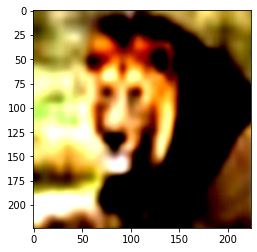

In [49]:
plt.imshow(images[117].permute(1, 2, 0).detach().cpu().numpy())

In [20]:
# csam_model.layers

In [19]:
csam_model.layers[1]

ConvolutionalSelfAttention(
  (input_padder): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (upsampler): Identity()
  (global_transform): Linear(in_features=192, out_features=192, bias=True)
)

# Experiment Results Plots

In [14]:
csam_swin_filter5 = [77.02, 77.17, 77.17, 73.05]
csam_swin_filter3 = [78.12, 78.82, 24.59, 14.61]
baseline = [77.58] * 4

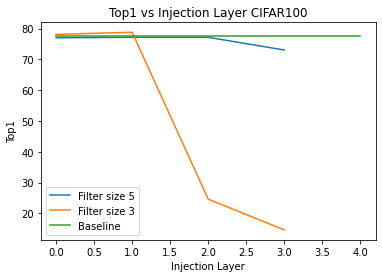

In [19]:
plt.plot(csam_swin_filter5, label="Filter size 5")
plt.plot(csam_swin_filter3, label="Filter size 3")
plt.plot(baseline, label="Baseline")
plt.title("Top1 vs Injection Layer CIFAR100")
plt.xlabel("Injection Layer")
plt.ylabel("Top1")
plt.legend()
plt.show()